# Procesamiento

## Adaptación a torch-geometric-temporal

https://arxiv.org/abs/2110.06324

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

In [2]:
from torch_geometric_temporal.nn.recurrent import GCLSTM

from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from utils.dynamic_graph_temporal_signal import DynamicGraphTemporalSignalLen
from utils import powergrid


In [3]:
def format_plot(ax):
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')

    ax.xaxis.label.set_color('dimgrey')
    ax.tick_params(axis='both', colors='dimgrey', size=12, pad=1)

In [4]:
folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"


In [5]:
loader = powergrid.PowerGridDatasetLoader(folder_path)


In [6]:
11*550

6050

In [7]:
dataset = loader.get_dataset( target= 50, intro=200, step=50)

Here
Processing:  row_214
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_32
Processing:  row_57
Processing:  row_110
Processing:  row_248
Processing:  row_119
Process

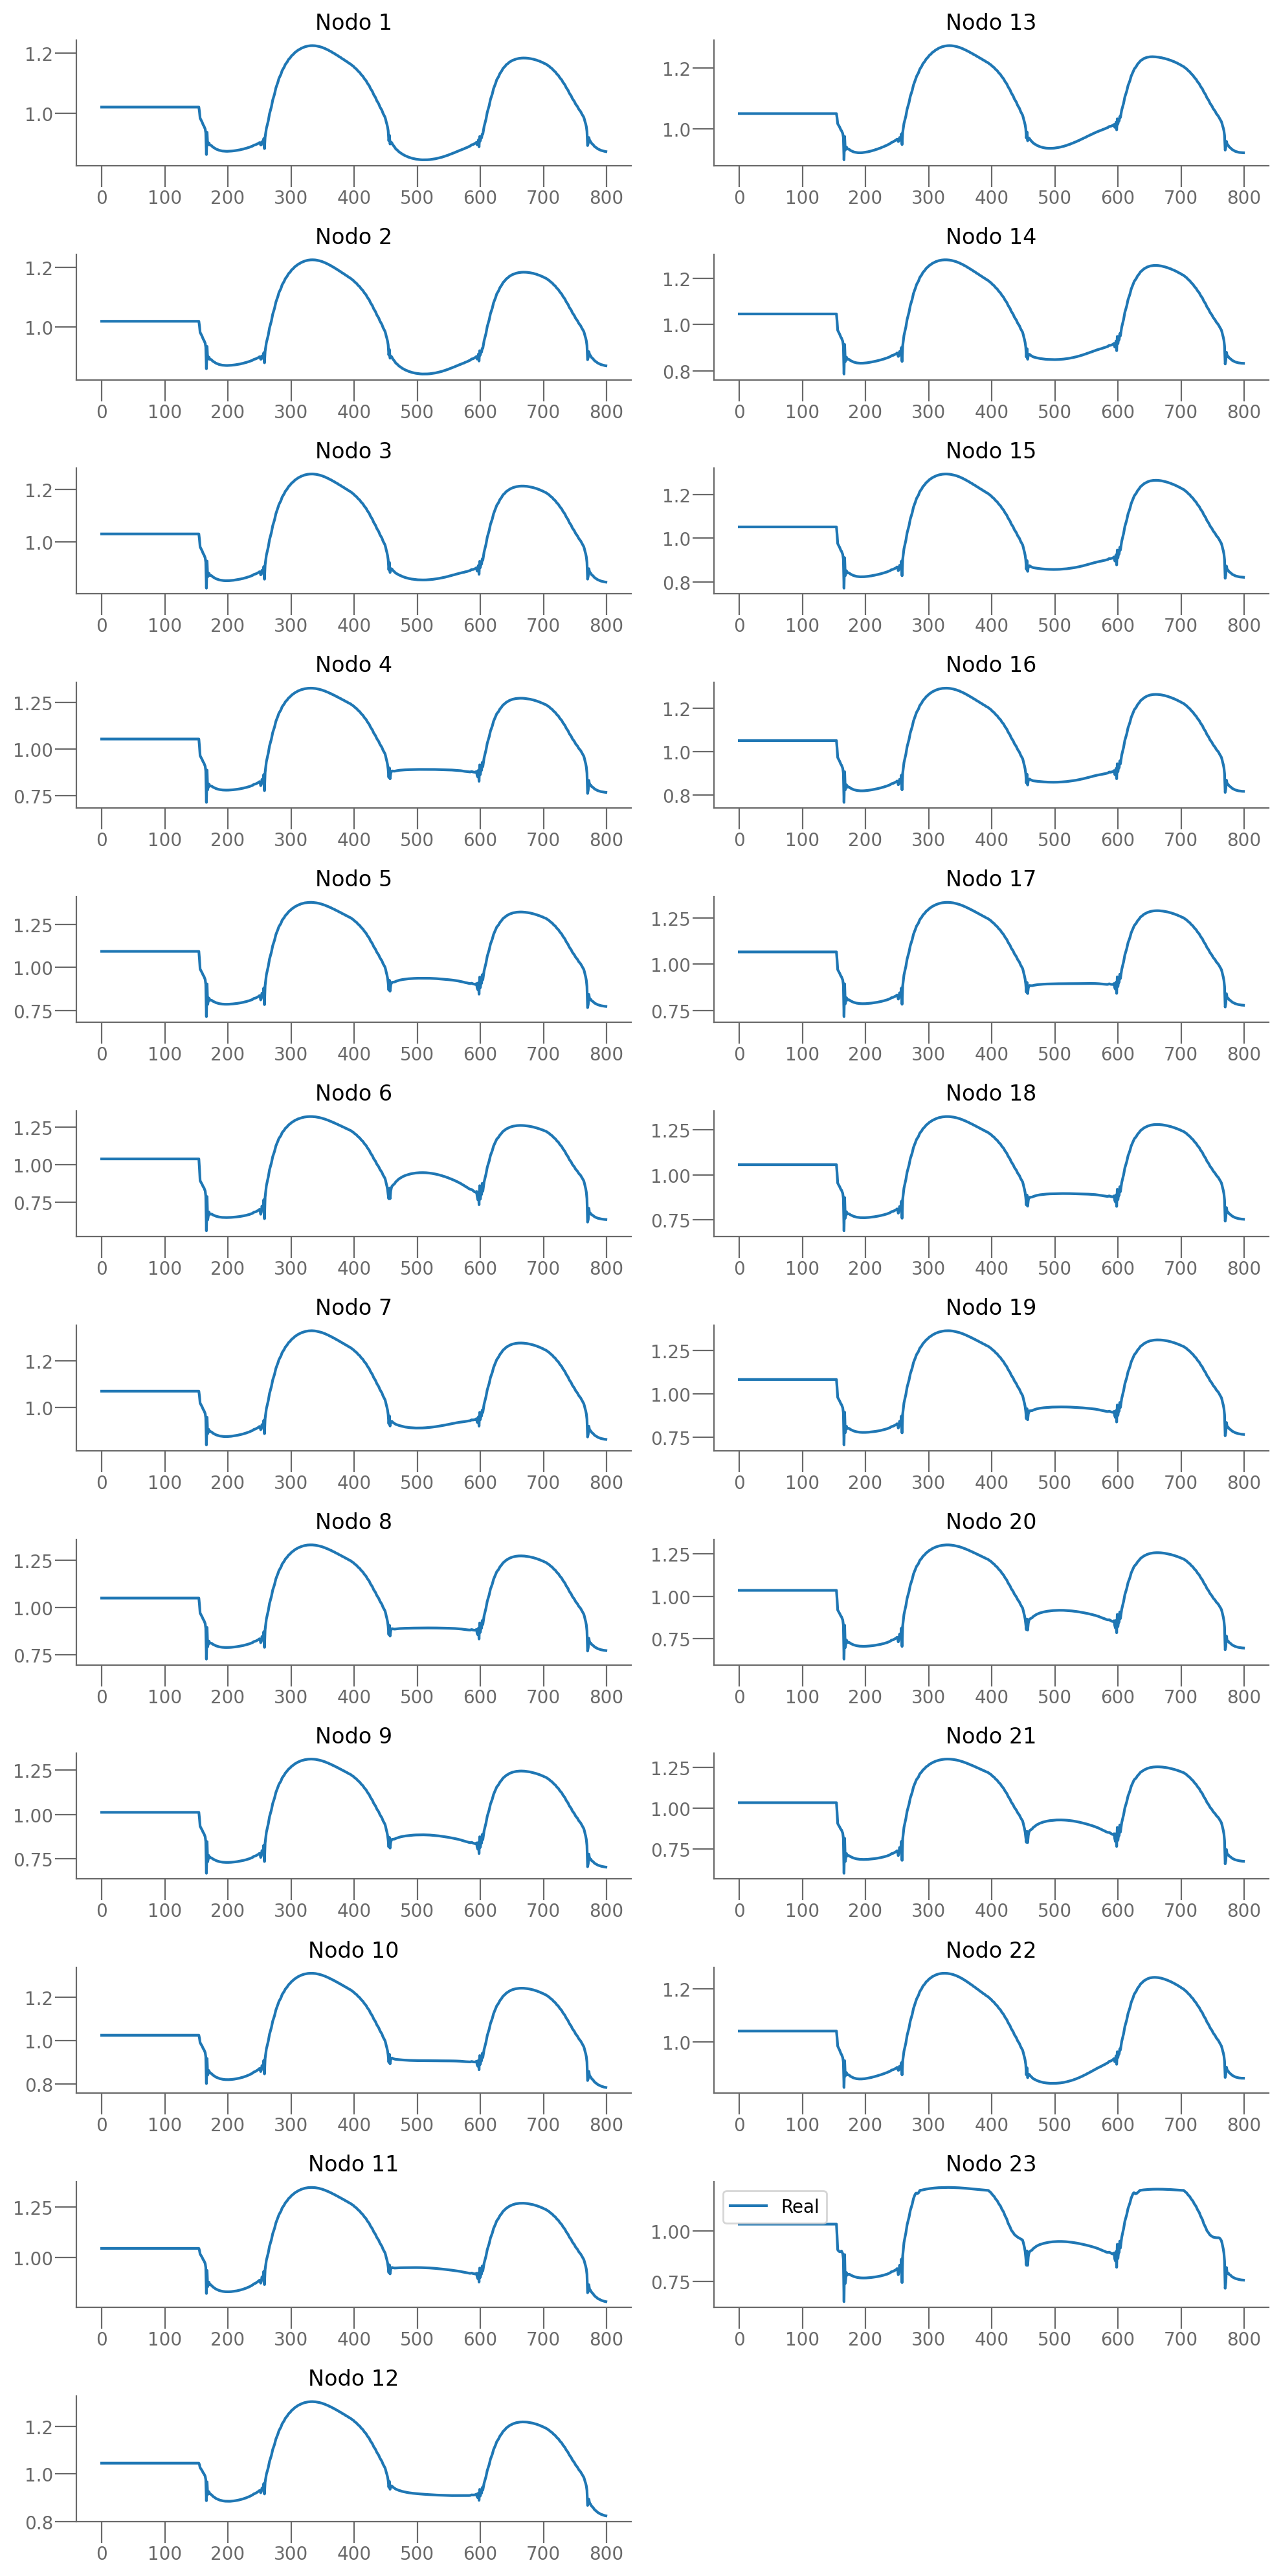

In [15]:
info_nodos = loader.reconstruir_voltages(10)


n_plots = 23
n_cols = 2
n_rows = (n_plots + 1) // 2  # División redondeada hacia arriba

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20),dpi=200)
# Trazar los gráficos
for i in range(n_plots):
    row = i % n_rows  # Calculamos el índice de la fila
    col = i // n_rows  # Calculamos el índice de la columna
    ax = axs[row, col] if n_plots > 1 else axs
    
    ax = axs[row, col] if n_plots > 1 else axs
    
    sns.lineplot(y=info_nodos[i],x=range(len(info_nodos[i])), ax=ax, label='Real', legend=False)
        
    ax.set_title(f'Nodo {i+1}')
    format_plot(ax)
    # Añadir leyenda solo al último plot
    if i == n_plots - 1:
        ax.legend(loc='upper left')

if n_plots % n_cols != 0:
    fig.delaxes(axs.flatten()[-1])
# Ajustes finales
plt.tight_layout()
plt.show()

## Experimentos 

Problema actual: mucho tiempo de entrenamiento - inclusión de batch?


### Red sencilla

In [7]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN



from utils.trainer import TrainerModel
from utils import trainer

In [8]:
dtype = torch.float
device = torch.device("cpu")

In [9]:
n_nodes =dataset.features[0].shape[0]
n_target = dataset.targets[0].shape[1]
n_features = dataset[0].x.shape[1]
embedding_dim =4

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, name):
        self.name  =name
        super(RecurrentGCN, self).__init__()

        self.recurrent = AGCRN(number_of_nodes = n_nodes,
                              in_channels = node_features,
                              out_channels = n_nodes,
                              K = 2,
                              embedding_dimensions = embedding_dim)
        self.linear = torch.nn.Linear(n_nodes,n_target)



    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0

In [10]:
model = RecurrentGCN(node_features = n_features, name = "RecurrentGCNInicial")

In [11]:

dataloader_params2 = {
            "batch_size": 10,
            "data_split_ratio": [0.8, 0.1, 0.1],
            "seed": 42
        }
dataloader = trainer.train_test_val_split(dataset, **dataloader_params2)


DataLoader for train set:
Number of batches: 175
DataLoader for val set:
Number of batches: 22
DataLoader for test set:
Number of batches: 22


In [14]:

dataloader_params2 = {
            "batch_size": 10,
            "data_split_ratio": [0.8, 0.1, 0.1],
            "seed": 42
        }
dataloader = trainer.train_test_val_split(dataset, **dataloader_params2)


num_epochs = 5
optimizer = torch.optim.Adam(model.parameters())
model.to(device)

losses = []
e = torch.empty(n_nodes, embedding_dim)
torch.nn.init.xavier_uniform_(e)
i =0
for epoch in range(num_epochs):
    model.train()
    h = None
    for batch in dataloader['train']:
        batch = batch.to(device)

        x = batch.x.view(len(batch), n_nodes, n_features)
        y_hat,h = model(x, e, h)
        loss = F.mse_loss(y_hat.view(-1, n_target), batch.y)
        loss.backward(retain_graph=True)
        losses.append(loss.item())
        optimizer.zero_grad()
        optimizer.step()
        i+=1
        #print("batch: ", i)
    train_loss =torch.FloatTensor(losses).mean().item()
    
    print(f"Epoch:{epoch}, Training_loss:{train_loss:.4f}")

DataLoader for train set:
Number of batches: 175
DataLoader for val set:
Number of batches: 22
DataLoader for test set:
Number of batches: 22


KeyboardInterrupt: 

In [27]:


train_params = {
"num_epochs": 5,
"num_early_stop":20
}

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = RecurrentGCN(node_features = n_features, name = "RecurrentGCNInicial")

trainer = TrainerModel(
            model=model,
            dataset=dataset,
            device=device,
            save_dir=os.path.join("./models/", dataset.name),
            dataloader_params=dataloader_params2)




trainer.train(train_params)

DataLoader for train set:
Number of batches: 176
DataLoader for val set:
Number of batches: 23
DataLoader for test set:
Number of batches: 22


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [ ]:

from utils.trainer import TrainerModel
from sklearn.metrics import balanced_accuracy_score, f1_score

In [35]:

model = RecurrentGCN(node_features = n_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

e = torch.empty(n_nodes, embedding_dim)

torch.nn.init.xavier_uniform_(e)

tensor([[-0.2497, -0.0414, -0.0629, -0.2463],
        [-0.1819,  0.2027, -0.1274, -0.2180],
        [ 0.3971, -0.4617,  0.0648,  0.3149],
        [-0.1729, -0.2819,  0.1764, -0.4176],
        [-0.3830,  0.2260,  0.0979, -0.2806],
        [ 0.3108, -0.1240, -0.3581, -0.2350],
        [ 0.2648, -0.4062,  0.2846,  0.2135],
        [-0.2635,  0.4128,  0.2368, -0.0828],
        [-0.2650, -0.2636, -0.0254,  0.0988],
        [-0.0123, -0.4485, -0.1291,  0.2317],
        [ 0.2486,  0.0138, -0.0517,  0.0973],
        [-0.2038, -0.0106, -0.0414, -0.1661],
        [-0.2562, -0.2789, -0.3787,  0.1855],
        [ 0.1105, -0.1524, -0.3116,  0.3842],
        [-0.2794, -0.4210, -0.4047,  0.1623],
        [-0.3523, -0.3376,  0.3343,  0.2225],
        [ 0.4685, -0.4326,  0.0081, -0.0721],
        [-0.3664,  0.0676,  0.2443, -0.2844],
        [ 0.2448, -0.2422, -0.0066, -0.2295],
        [-0.0819,  0.0456,  0.3223, -0.4057],
        [ 0.0383, -0.2170, -0.4210,  0.3584],
        [-0.3115, -0.2429,  0.0053

In [36]:
for epoch in tqdm(range(200)):
    cost = 0
    h = None
    for time, snapshot in enumerate(train_dataset):
        x = snapshot.x.view(1, n_nodes, n_features)
        y_hat, h = model(x, e, h)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()


  0%|          | 1/200 [00:13<44:17, 13.35s/it]


KeyboardInterrupt: 

In [ ]:
len(train_dataset.features)

165

In [233]:

predictions = []
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    x = snapshot.x.view(1, n_nodes, n_features)
    y_hat, h = model(x, e, h)
    predictions.append(y_hat.squeeze())
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.0195


In [236]:
def format_plot(ax):
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')

    ax.xaxis.label.set_color('dimgrey')
    ax.tick_params(axis='both', colors='dimgrey', size=12, pad=1)

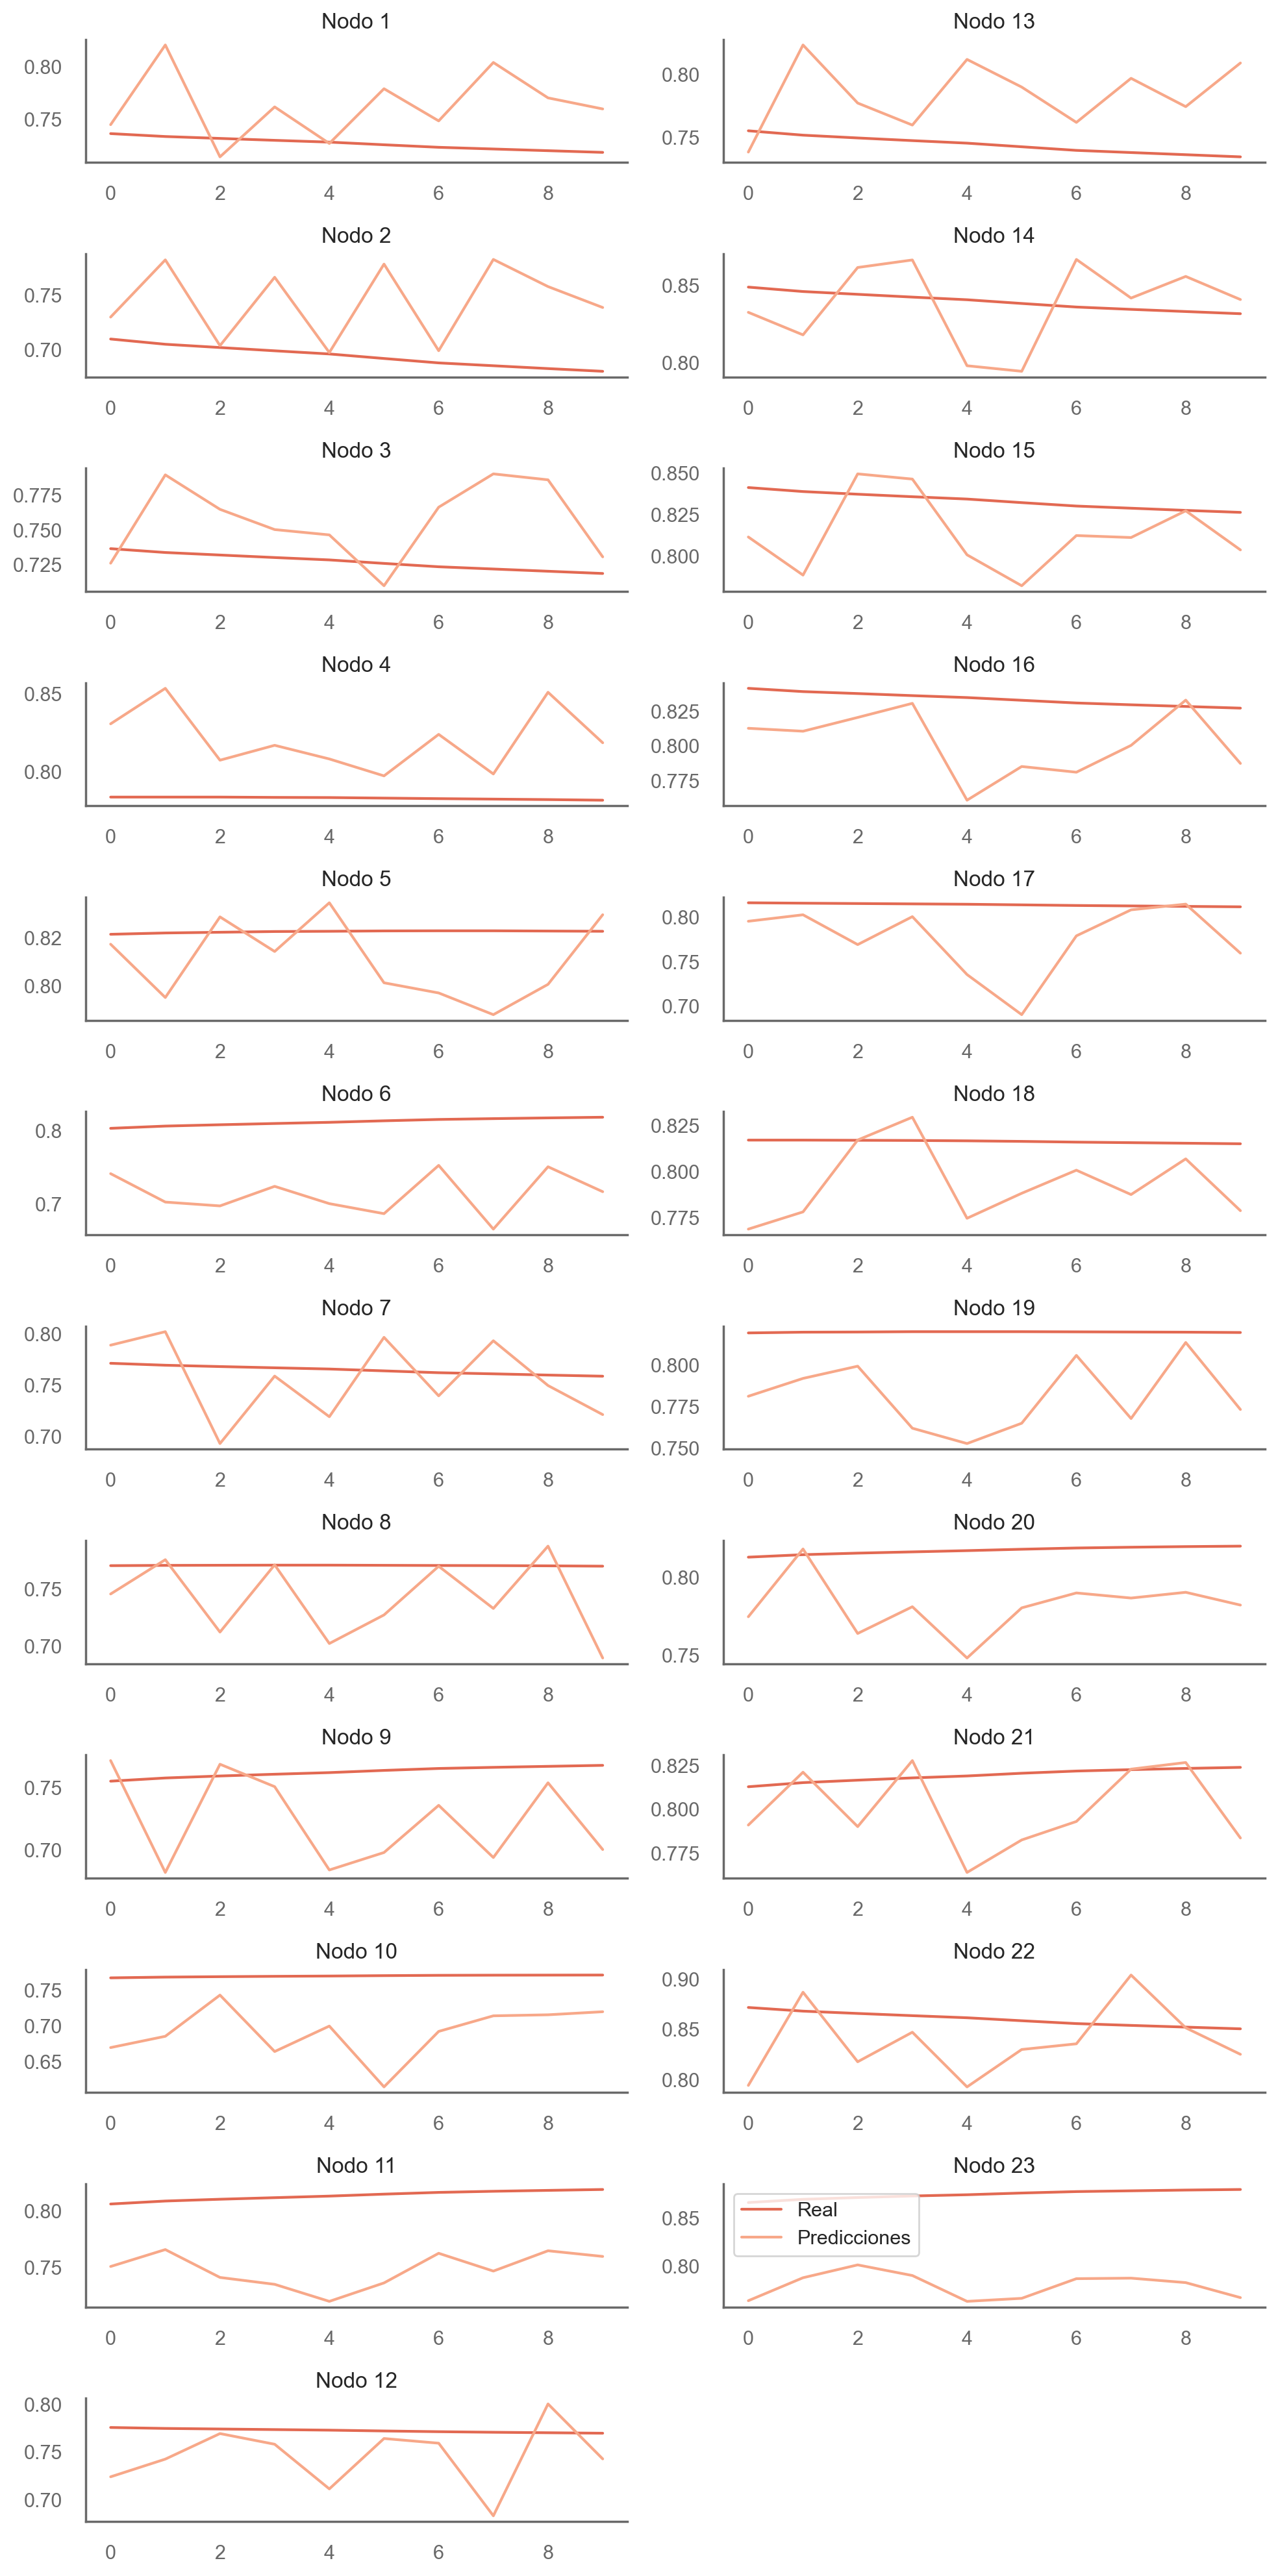

In [238]:
n_situation = 1
predictions_situation = predictions[n_situation].tolist()
real_situation = test_dataset.targets[n_situation].tolist()
n_plots = 23
n_cols = 2
n_rows = (n_plots + 1) // 2  # División redondeada hacia arriba

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20),dpi=200)
# Trazar los gráficos
for i in range(n_plots):
    row = i % n_rows  # Calculamos el índice de la fila
    col = i // n_rows  # Calculamos el índice de la columna
    ax = axs[row, col] if n_plots > 1 else axs
    
    ax = axs[row, col] if n_plots > 1 else axs
    
    sns.lineplot(y=real_situation[i],x=range(n_target), ax=ax, label='Real', legend=False)
    

    sns.lineplot(y=predictions_situation[i],x=range(n_target),ax=ax, label='Predicciones', legend=False)
    
    ax.set_title(f'Nodo {i+1}')
    format_plot(ax)
    # Añadir leyenda solo al último plot
    if i == n_plots - 1:
        ax.legend(loc='upper left')

if n_plots % n_cols != 0:
    fig.delaxes(axs.flatten()[-1])
# Ajustes finales
plt.tight_layout()
plt.show()